# Extracting radar values at rain gauge locations (single scan)

This notebook shows the workflow of extracting the radar values at rain gauge locations, and comparing the values (timezone-aware). It will be divided into four sections:

1. Download and read reflectivity data
2. Convert reflectivity to rain rate
3. Get radar data observations at gauge locations
4. Compare radar vs gauge observations

Import libraries.

In [1]:
%pylab inline

import pyart
import wradlib as wrl
import pandas as pd
import tempfile
import os

import pytz
import datetime as dt

from copy import deepcopy
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature

Populating the interactive namespace from numpy and matplotlib

## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
import boto3
from botocore.handlers import disable_signing

/home/ac.jcorner/anaconda3/envs/rainfall/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
def rounder(t):
    """
    Rounds the time to the nearest hour.
    """
    if t.minute >= 30:
        return t.replace(second=0, microsecond=0, minute=0, hour=t.hour+1)
    else:
        return t.replace(second=0, microsecond=0, minute=0)

/home/ac.jcorner/anaconda3/envs/rainfall/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 1. Download data

NEXRAD data is downloaded from Amazon S3.

Define function to download data.

In [4]:
def get_radar_scan(station='KLOT', date=None, key_index=-20):
    
    '''
    Function will pull the latest radar scan from any radar site using 
    Amazon S3.
    ----------
    Station = Four letter NEXRAD identifier
              Example: 'KEPZ'
    Date = default is none for current date, else enter date in format "YYYY/MM/DD"
    Ex: date ='2013/11/17
    Key_index = Number of keys you want pulled from most recent scan.
    Ex: key_index = -15 would pull ht most recent 15 scans
    '''
    
    # Creating a bucket and a client to be able to pull data from AWS and setting it as unsigned
    bucket = 'noaa-nexrad-level2'
    s3 = boto3.resource('s3')
    s3.meta.client.meta.events.register('choose-signer.s3.*', disable_signing)
    
    # Connects the bucket create above with radar data
    aws_radar = s3.Bucket(bucket)
    
    # Setting the date and time to current...
    # This will allow for allow the current date's radar scands to be pulled
    if date == None:
        target_string = datetime.datetime.utcnow().strftime('%Y/%m/%d/'+station)
    else:
        target_string = date+'/'+station
    
    for obj in aws_radar.objects.filter(Prefix= target_string):
        '{0}:{1}'.format(aws_radar.name, obj.key)
    my_list_of_keys = [this_object.key for this_object in aws_radar.objects.filter(Prefix= target_string)]
    keys = my_list_of_keys[key_index:]
    newkeys = []
    for key in keys:
        if 'MDM' in key:
            pass
        elif key.endswith('.tar'):
            pass
        else:
            newkeys.append(key)
    #print(newkeys)
    return aws_radar, newkeys

/home/ac.jcorner/anaconda3/envs/rainfall/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Get the filenames of the available files for download, for the specified radar `station` (KLOT for Chicago), `date`, and `key_index`. `key_index` refers to the N most recent files.

In [5]:
# Setting radar, date of radar scans needed, and key index (amount of items in list)
aws_radar, keys = get_radar_scan(station='KLOT', date='2021/06/12', key_index=-400) 

/home/ac.jcorner/anaconda3/envs/rainfall/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
print(keys)

['2021/06/12/KLOT/KLOT20210612_000507_V06', '2021/06/12/KLOT/KLOT20210612_001008_V06', '2021/06/12/KLOT/KLOT20210612_001454_V06', '2021/06/12/KLOT/KLOT20210612_001941_V06', '2021/06/12/KLOT/KLOT20210612_002414_V06', '2021/06/12/KLOT/KLOT20210612_002848_V06', '2021/06/12/KLOT/KLOT20210612_003251_V06', '2021/06/12/KLOT/KLOT20210612_003702_V06', '2021/06/12/KLOT/KLOT20210612_004117_V06', '2021/06/12/KLOT/KLOT20210612_004521_V06', '2021/06/12/KLOT/KLOT20210612_004925_V06', '2021/06/12/KLOT/KLOT20210612_005329_V06', '2021/06/12/KLOT/KLOT20210612_005741_V06', '2021/06/12/KLOT/KLOT20210612_010145_V06', '2021/06/12/KLOT/KLOT20210612_010602_V06', '2021/06/12/KLOT/KLOT20210612_011014_V06', '2021/06/12/KLOT/KLOT20210612_011411_V06', '2021/06/12/KLOT/KLOT20210612_011822_V06', '2021/06/12/KLOT/KLOT20210612_012227_V06', '2021/06/12/KLOT/KLOT20210612_012653_V06', '2021/06/12/KLOT/KLOT20210612_013125_V06', '2021/06/12/KLOT/KLOT20210612_013611_V06', '2021/06/12/KLOT/KLOT20210612_014058_V06', '2021/06/1

/home/ac.jcorner/anaconda3/envs/rainfall/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Get subset of keys, for example every 5 scans.

In [7]:
newkeys=keys[0:200:10]

/home/ac.jcorner/anaconda3/envs/rainfall/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Using the function defined above, we can download the file, save it to a temporary file, read the radar object using `pyart`, then delete the file to save space.

In [8]:
# loop through the keys by iterating nframe
nframe = 14

# open a temporary local file
localfile = tempfile.NamedTemporaryFile(delete=False)
localfile_name = localfile.name
localfile.close()

# download to temporary file and read to radar object using pyart
aws_radar.download_file(newkeys[nframe], localfile_name)
radar = pyart.io.read(localfile_name)

# delete temporary file to save space
os.remove(localfile_name)

/home/ac.jcorner/anaconda3/envs/rainfall/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Get the time from the filename, and convert it to local time. The local time is used for finding the corresponding gauge time (all of which are in local times) as well as for the display.

In [9]:
# set the timezone
timezone = pytz.timezone("America/Chicago")

fname = newkeys[nframe].rsplit('/',1)[-1].strip('.gz')
dtime_utc = dt.datetime.strptime(fname,'KLOT%Y%m%d_%H%M%S_V06')
dtime_utc = pytz.utc.localize(dtime_utc)
dtime_local = dtime_utc.astimezone(timezone)

/home/ac.jcorner/anaconda3/envs/rainfall/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
dtime_local

/home/ac.jcorner/anaconda3/envs/rainfall/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


datetime.datetime(2021, 6, 12, 8, 4, 32, tzinfo=<DstTzInfo 'America/Chicago' CDT-1 day, 19:00:00 DST>)

In [11]:
dtime_local_hr = rounder(dtime_local)

/home/ac.jcorner/anaconda3/envs/rainfall/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 2. Convert reflectivity to rain rate

The radar object contains reflectivty data, among other variables. We want to calculate the rain rate, so we convert reflectivity to rain rate using `pyart.retrieve.est_rain_rate_z`.

In [12]:
gatefilter = pyart.filters.GateFilter(radar)
# Develop your gatefilter first
# exclude masked gates from the gridding
#gatefilter = pyart.filters.GateFilter(radar)
gatefilter.exclude_transition()
gatefilter.exclude_masked('reflectivity')
# Mask reflectivity
radar.fields["corrected_reflectivity"] = deepcopy(radar.fields["reflectivity"])
radar.fields["corrected_reflectivity"]["data"] = np.ma.masked_where(
    gatefilter._gate_excluded, radar.fields["corrected_reflectivity"]["data"])
rr = pyart.retrieve.est_rain_rate_z(radar, refl_field="corrected_reflectivity")

/home/ac.jcorner/anaconda3/envs/rainfall/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Add the new rainrate field to the radar object.

In [13]:
radar.add_field('rainrate',rr,replace_existing=True)

/home/ac.jcorner/anaconda3/envs/rainfall/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
# Mask out last 10 gates of each ray, this removes the "ring" around the radar.
radar.fields['rainrate']['data'][:, -10:] = np.ma.masked

/home/ac.jcorner/anaconda3/envs/rainfall/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
#rainamount = 

/home/ac.jcorner/anaconda3/envs/rainfall/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 2.1 Grid the rain rate data

`grid_shape` is num_z, num_y, and num_x

`grid_limits` is z_lim, y_lim, x_lim

such that `grid_shape=(4, 241, 241)` and `grid_limits=((1000, 3000), (-123000.0, 123000.0), (-123000.0, 123000.0))` will produce a gridded data with 4 altitudes between 1000m and 3000m, with 241 pixels between -123m and 123m in x and y.

In [16]:
# perform Cartesian mapping, limit to the reflectivity field.
grid = pyart.map.grid_from_radars(
    [radar], gatefilters=[gatefilter],
    grid_shape=(1, 300, 300),
    grid_limits=((2000, 2000), (-123000.0, 123000.0), (-123000.0, 123000.0)),
    fields=['rainrate'])

/home/ac.jcorner/anaconda3/envs/rainfall/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/ac.jcorner/anaconda3/envs/rainfall/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:166: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990. Default will be switched to Barnes2 on June 1st.
  warnings.warn("Barnes weighting function is deprecated."


Now that we have the gridded rain rate, let's have a look at one of CAPPI levels.

/home/ac.jcorner/anaconda3/envs/rainfall/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/ac.jcorner/anaconda3/envs/rainfall/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/50m/cultural/ne_50m_admin_1_states_provinces_lines.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/home/ac.jcorner/anaconda3/envs/rainfall/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/physical/ne_10m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


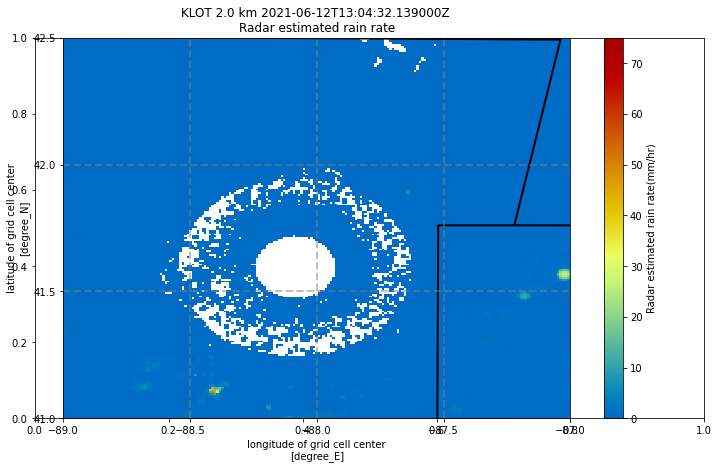

In [17]:
projection = ccrs.PlateCarree()

fig = plt.figure(figsize=[12,7])
display = pyart.graph.GridMapDisplay(grid)
display.plot_grid('rainrate', cmap=pyart.graph.cm_colorblind.HomeyerRainbow,
                  vmin=0, vmax=75, lat_lines=np.arange(41, 43, .5),
                  lon_lines=np.arange(-89, -86.5, .5), projection=projection, embelish=True)

# 3. Get radar values at gauge locations

### 3.1 Preparing the gauge data

#### 3.1.1 Reading the data

Now let's load the locations and data for the rain gauges and read them into a pandas dataframe.

In [28]:
# load CCN gauge locations
CCN_gauge_locations_fname = '/home/ac.jcorner/Rainfall/CookCounty_gage_locations.csv'
# load CCN gauge observations
CCN_gauge_observations_fname = '/home/ac.jcorner/Rainfall/WaterYear2013_hourlyprecip.csv'

/home/ac.jcorner/anaconda3/envs/rainfall/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
df_gauge_loc = pd.read_csv(CCN_gauge_locations_fname,header=0)
df_gauge = pd.read_csv(CCN_gauge_observations_fname,header=0)

/home/ac.jcorner/anaconda3/envs/rainfall/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
df_gauge_loc.head(10)

/home/ac.jcorner/anaconda3/envs/rainfall/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,City,Closest Major Intersection,Station Number,Latitude,Longitude - West
0,Northbrook,near Landwehr Rd and Willow Rd,1,42.1109,-87.8682
1,Winnetka,near Hibbard Rd and Willow Rd,2,42.1073,-87.7566
2,Des Plaines,near S River Rd and E Oakton St,3,42.0225,-87.8778
3,Skokie,near Lincoln Ave and Oakton St,4,42.0276,-87.7554
4,Franklin Park,near Mannheim Rd and Grand Ave,5,41.9320,-87.8782
5,Chicago,near N Central Ave and W Grand Ave,6,41.9168,-87.7617
6,Chicago,near N Clark St and W Irving Park Rd,7,41.9590,-87.6574
7,Westchester,near N La Grange Rd and W Cermak Rd,8,41.8448,-87.8822
8,Cicero,near S Laramie Ave and W Roosevelt Rd,9,41.8650,-87.7547
9,Chicago,near S Halsted St and W. Cermak Rd,10,41.8451,-87.6483


In [31]:
df_gauge.head()

/home/ac.jcorner/anaconda3/envs/rainfall/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Date/Time,G1,G2,G3,G4,G5,G6,G7,G8,G9,...,G21,G22,G23,G24,G25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30
0,10/1/2012 1:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,10/1/2012 2:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2,10/1/2012 3:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
3,10/1/2012 4:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4,10/1/2012 5:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN


Here we set `x` and `y` variables to have the longitude and latitude coordinates of the rain gauges, respectively.

In [32]:
x = df_gauge_loc['Longitude - West'].values
y = df_gauge_loc['Latitude'].values

/home/ac.jcorner/anaconda3/envs/rainfall/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Before proceeding, make sure that the radar timestamps and gauge timestamps can be compared. The radar timestamp was made to we timezone aware, so now let's do that for the gauge timestamps.

First let's convert the `Date/Time` string column to a datetime column.

In [33]:
df_gauge['Datetime'] = pd.to_datetime(df_gauge['Date/Time'])

/home/ac.jcorner/anaconda3/envs/rainfall/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Then localize the timestamp to be timezone aware. Ambiguous and non-existent values might occur during DST transitions. Here they are just converted to NaT.

In [34]:
df_gauge['Datetime'] = df_gauge['Datetime'].dt.tz_localize(timezone,ambiguous='NaT',nonexistent ='NaT')

/home/ac.jcorner/anaconda3/envs/rainfall/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Now we want to extract the gauge readings concurrent with the radar observation.

In [35]:
str(dtime_local_hr)

/home/ac.jcorner/anaconda3/envs/rainfall/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'2021-06-12 08:00:00-05:00'

Get the gauge values at a certain time and convert it from inches to mm.

In [65]:
gauge_values = df_gauge.loc[df_gauge['Datetime'] == dtime_local_hr][df_gauge.columns[1:26]].values*25.4

/home/ac.jcorner/anaconda3/envs/rainfall/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Now we have the gauge data!

#### 3.2.2 Plotting the gauge locations with the radar data

Just so we have some context where the gauges are, with respect to the radar data, let's plot them together.

First we have to load the shapefiles.

In [51]:
reader = shpreader.Reader(r'/home/ac.jcorner/Rainfall/tl_2016_17_cousub/tl_2016_17_cousub.shp')
counties = list(reader.geometries())
COUNTIES = cfeature.ShapelyFeature(counties, ccrs.PlateCarree())

/home/ac.jcorner/anaconda3/envs/rainfall/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Then plot.

/home/ac.jcorner/anaconda3/envs/rainfall/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


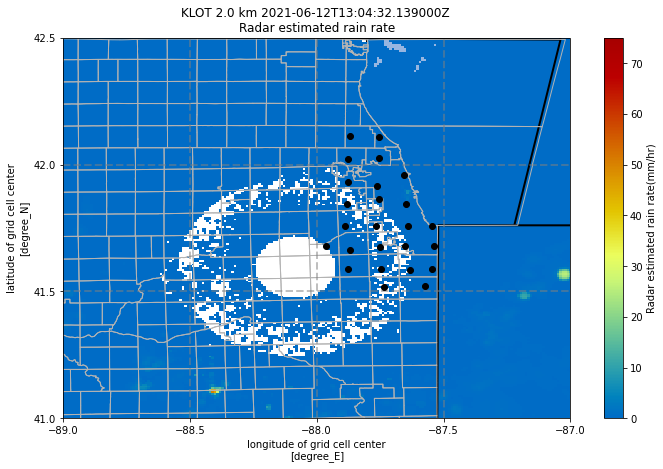

In [52]:
projection = ccrs.PlateCarree()

fig = plt.figure(figsize=[12,7])
ax = plt.axes(projection=projection)
display = pyart.graph.GridMapDisplay(grid)
display.plot_grid('rainrate', cmap=pyart.graph.cm_colorblind.HomeyerRainbow,
                  vmin=0, vmax=75, lat_lines=np.arange(41, 43, .5),
                  lon_lines=np.arange(-89, -86.5, .5), projection=projection, embelish=True)
plt.plot(x,y,'ko')

ax.add_feature(COUNTIES, facecolor='none', edgecolor='0.7')
ax.add_feature(cfeature.LAKES, zorder=.5, edgecolor='k')

### 3.2 Preparing the radar data

In this part of the script, we make use of the `wradlib` function to extract radar values at gauge locations. `wradlib` uses simple arrays as the data model, which is different from that of `pyart`. To prepare the data for input in `wradlib`, we get the slice of the rain rate from the radar object.

In [53]:
radar_slice0 = radar.get_slice(0)
rr_0 = radar.fields['rainrate']['data'][radar_slice0, :]

/home/ac.jcorner/anaconda3/envs/rainfall/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The `wradlib` function requires the site coordinates, the azimuths, the range gates, and the projection in addition to the gauge coordinates (which we set earlier as `x` and `y`). We can extract them from the `radar` object.

In [54]:
sitecoords = (radar.longitude['data'][0],radar.latitude['data'][0])
az = radar.azimuth['data'][radar_slice0]
r = radar.range['data']

/home/ac.jcorner/anaconda3/envs/rainfall/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [55]:
proj = wrl.georef.epsg_to_osr(4326)

/home/ac.jcorner/anaconda3/envs/rainfall/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Calculate the polar coordinates of the nearest grid cells surrounding the rain gauge. To account for the difference in spatial representativeness of the gauge and radar cell, we take the 9 nearest neighbors of the radar grid cell directly above the radar and average them.

In [56]:
polarneighbs = wrl.verify.PolarNeighbours(r, az, sitecoords, proj, x,y, nnear=9)
radar_at_gages = polarneighbs.extract(rr_0)

radar_at_gages_mean = np.mean(radar_at_gages,axis=1)

/home/ac.jcorner/anaconda3/envs/rainfall/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/ac.jcorner/anaconda3/envs/rainfall/lib/python3.9/site-packages/wradlib/georef/polar.py:512: UserWarning: The azimuth angles of the current dataset are not equidistant.
  warnings.warn(


Now we have the radar data!

Just to see which radar bins are considered, let's plot the neighboring 9 bins around each gauge location.

In [57]:
binx, biny = polarneighbs.get_bincoords()
binx_nn, biny_nn = polarneighbs.get_bincoords_at_points()

/home/ac.jcorner/anaconda3/envs/rainfall/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/ac.jcorner/anaconda3/envs/rainfall/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


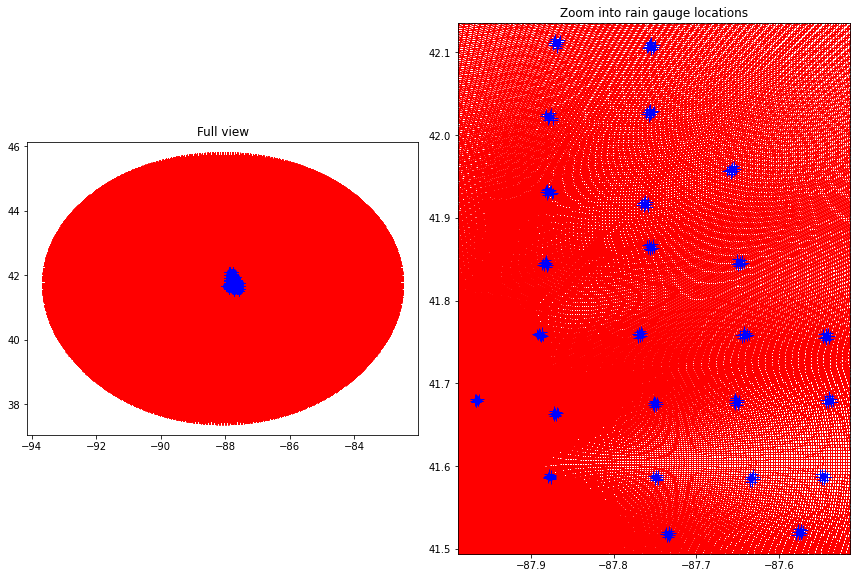

In [58]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(121)
ax.plot(binx, biny, 'r+')
ax.plot(binx_nn, biny_nn, 'b+', markersize=10)
ax.plot(x, y, 'bo')
ax.axis('tight')
ax.set_aspect("equal")
plt.title("Full view")
ax = fig.add_subplot(122)
ax.plot(binx, biny, 'r+')
ax.plot(binx_nn, biny_nn, 'b+', markersize=10)
ax.plot(x, y, 'bo')
plt.xlim(binx_nn.min()-0.02, binx_nn.max()+0.02)
plt.ylim(biny_nn.min()-0.02, biny_nn.max()+0.02)
# plt.xlim(-87.9,-87.74)
# plt.ylim(42.0, 42.14)
ax.set_aspect("equal")
txt = plt.title("Zoom into rain gauge locations")
plt.tight_layout()

## 4. Comparing radar vs rain gauge

Now we can compare the radar observations vs the rain gauge readings.

In [59]:
gauge_values

/home/ac.jcorner/anaconda3/envs/rainfall/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([], shape=(0, 25), dtype=float64)

In [60]:
radar_at_gages_mean

/home/ac.jcorner/anaconda3/envs/rainfall/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


masked_array(data=[0.04243093066745334, 0.02641966938972473,
                   0.03689117357134819, 0.04561297098795573,
                   0.05613924397362603, 0.1377334859636095,
                   0.5561822255452474, 0.08472761180665758,
                   0.19597913159264457, 0.1575759251912435,
                   0.07045336564381917, 0.24116947915818956,
                   0.6860043207804362, 0.5209236674838595,
                   0.05466564496358236, 0.08079461256663005,
                   0.08987563186221653, 0.12401409943898518,
                   0.050032463338640004, 0.05130284031232198,
                   0.07420005400975545, 0.06630956464343601,
                   0.10146539741092259, 0.14239480760362414,
                   0.070358587635888],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
        

Make a scatter plot:

/home/ac.jcorner/anaconda3/envs/rainfall/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ValueError: x and y must be the same size

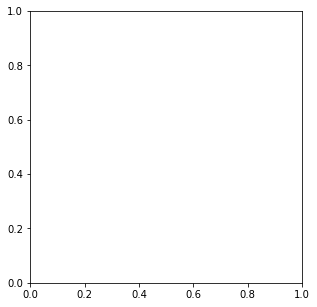

In [61]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111,aspect='equal')
plt.scatter(gauge_values,radar_at_gages_mean)
plt.plot((0,60),(0,60),color='0.7',zorder=-.5)
plt.xlabel('Gauge (mm)')
plt.ylabel('Radar (mm)')
plt.xlim(0,20)
plt.ylim(0,20)

Plot the rain gauge data on top of the radar data using the same colorscale and see if they match.

/home/ac.jcorner/anaconda3/envs/rainfall/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


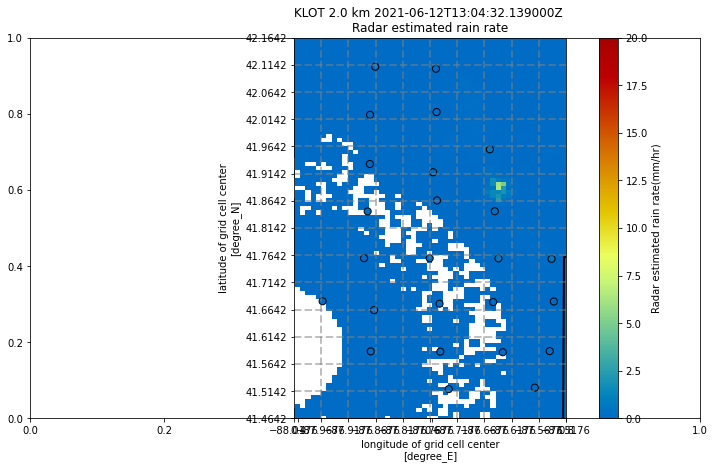

In [62]:
projection = ccrs.PlateCarree()

fig = plt.figure(figsize=[12,7])
display = pyart.graph.GridMapDisplay(grid)
display.plot_grid('rainrate', cmap=pyart.graph.cm_colorblind.HomeyerRainbow,
                  vmin=0, vmax=20, lat_lines=np.arange(biny_nn.min()-0.05, biny_nn.max()+0.05,0.05),
                  lon_lines=np.arange(binx_nn.min()-0.05, binx_nn.max()+0.05,0.05), projection=projection, embelish=True)
plt.scatter(x,y,c=radar_at_gages_mean,s=50,lw=1,edgecolor='k',cmap=pyart.graph.cm_colorblind.HomeyerRainbow,vmin=0, vmax=20)